## Filter target patients 

### Import most libraries needed 

In [1]:
import pandas as pd
from constants import MIMIC_PATH, TEMP_PATH

### Define most constants needed
- CKD: Chronic kidney disease (suy thận mãn tính)
- DKA: Diabetic ketoacidosis (đái tháo đường)

In [2]:
from constants import CKD5_CODE_V10, CKD5_CODE_V9, DKA_CODE_V10, DKA_CODE_V9

# Define ICD-9/10 codes for DKA
dkaCode9 = DKA_CODE_V9
dkaCode10 = DKA_CODE_V10

print(dkaCode9)
print(dkaCode10)


# Define CKD stage 5 codes
ckd5Code9 = CKD5_CODE_V9
ckd5Code10 = CKD5_CODE_V10

print(ckd5Code9)
print(ckd5Code10)


['24910', '24911', '25010', '25011', '25012', '25013']
['E081', 'E0810', 'E0811', 'E091', 'E0910', 'E0911', 'E101', 'E1010', 'E1011', 'E111', 'E1110', 'E1111', 'E131', 'E1310', 'E1311']
['40301', '40311', '40391', '40402', '40403', '40412', '40413', '40492', '40493', '5855', '5856']
['I120', 'I1311', 'I132', 'N185', 'N186']


### Filter patients 
1. Only patients that caught DKA
1. Filtering repeated admissions during one hospitalization, take first
1. Remove attributes with more than 20% missing data

#### Read icd_code 

In [3]:
dfDiagnosesIcd = pd.read_csv(str(MIMIC_PATH / "hosp" / "diagnoses_icd.csv"))


# refine some column data
dfDiagnosesIcd["icd_code"] = dfDiagnosesIcd["icd_code"].astype(str)
dfDiagnosesIcd["icd_version"] = dfDiagnosesIcd["icd_version"].astype(int)

dfDiagnosesIcd

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9
...,...,...,...,...,...
4756321,19999987,23865745,7,41401,9
4756322,19999987,23865745,8,78039,9
4756323,19999987,23865745,9,0413,9
4756324,19999987,23865745,10,36846,9


#### Patients that caught DKA

In [4]:
dkaCondition = (
    (dfDiagnosesIcd["icd_version"] == 10)
    & dfDiagnosesIcd["icd_code"].isin(dkaCode10)
) | (
    (dfDiagnosesIcd["icd_version"] == 9)
    & (dfDiagnosesIcd["icd_code"].isin(dkaCode9))
)

dfDkaDiagnoses = dfDiagnosesIcd[dkaCondition]
dfDkaDiagnoses.__len__()

2011

#### CKD stage 5 dianogses 

In [5]:
ckd5Condition = (
    (dfDiagnosesIcd["icd_version"] == 9)
    & dfDiagnosesIcd["icd_code"].isin(ckd5Code9)
) | (
    (dfDiagnosesIcd["icd_version"] == 10)
    & dfDiagnosesIcd["icd_code"].isin(ckd5Code10)
)

dfCkd5Diagnoses = dfDiagnosesIcd[ckd5Condition]
dfCkd5Diagnoses

,subject_id,hadm_id,seq_num,icd_code,icd_version
3570,10005749,24979738,2,5856,9
3571,10005749,24979738,3,40391,9
5324,10010471,21322534,2,N186,10
5340,10010471,29842315,2,N186,10
5347,10010471,29842315,9,I132,10
...,...,...,...,...,...
4748842,19984992,29117747,6,5856,9
4751222,19989783,26984195,4,N186,10
4751229,19989783,26984195,11,I132,10
4753342,19993776,25402844,3,40391,9


#### Exclude all admission with CKD 5 

In [6]:
dfDkaExcludeCkd5 = dfDkaDiagnoses[
    ~dfDkaDiagnoses["hadm_id"].isin(dfCkd5Diagnoses["hadm_id"])
]
dfDkaExcludeCkd5

,subject_id,hadm_id,seq_num,icd_code,icd_version
922,10002013,21763296,2,E1110,10
6459,10012942,25710228,1,25013,9
8468,10015860,25085565,2,25012,9
9580,10018862,29501040,3,E1110,10
11494,10023239,21759936,2,E1010,10
...,...,...,...,...,...
4730603,19942407,29950646,1,25012,9
4731345,19944287,24067633,2,25013,9
4731358,19944287,24212516,3,25013,9
4751027,19989302,21980453,1,E1110,10


#### Exclude multiple admission
TODO: check legitimate of this action 

1. read icu stay
1. group by admission id (hadm_id), get first "intime"
1. join with data above by hadm


##### read data and remove duplicate

In [7]:
dfIcu = pd.read_csv(MIMIC_PATH / "icu" / "icustays.csv")
dfIcu["intime"] = pd.to_datetime(dfIcu["intime"])
dfIcuNoDup = dfIcu.drop_duplicates(
    subset="hadm_id", keep="first"
)
dfIcuNoDup

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588
...,...,...,...,...,...,...,...,...
73176,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370
73177,19999625,25304202,31070865,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2139-10-10 19:18:00,2139-10-11 18:21:28,0.960741
73178,19999828,25744818,36075953,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995
73179,19999840,21033226,38978960,Trauma SICU (TSICU),Surgical Intensive Care Unit (SICU),2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766


##### join admission

We will get patients who got dka but no ckd5, and went to ICD 

In [8]:
# check columns duplicate before hand 
sharedColumns = set(dfDkaExcludeCkd5.columns) & set(dfIcuNoDup.columns)
sharedColumns.remove("hadm_id")

sharedColumns

{'subject_id'}

In [9]:
dfTargetPatients = dfDkaExcludeCkd5.merge(
    dfIcuNoDup, 
    on="hadm_id", 
    how="inner",
    suffixes=("_icd", "_icu")
)

# remove duplicated columns 
for col in sharedColumns:
    dfTargetPatients[col] = dfTargetPatients.apply(lambda row: row[col + '_icd'] if row[col + '_icd'] == row[col + '_icu'] else None, axis=1) # type: ignore
    
    # if there is a none, the data is not match, abort merge duplicate columns  
    if None in dfTargetPatients[col].values:
        dfTargetPatients.drop(col, axis=1, inplace=True)
        pass
    else:
        dfTargetPatients.drop([col + '_icd', col + '_icu'], axis=1, inplace=True)
        pass
    pass

dfTargetPatients.sort_values(["hadm_id"], inplace=True)


dfTargetPatients

,hadm_id,seq_num,icd_code,icd_version,stay_id,first_careunit,last_careunit,intime,outtime,los,subject_id
1128,20027438,1,E1010,10,30213832,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),2119-04-07 22:09:11,2119-04-09 18:37:49,1.853218,19277038
854,20041225,1,E1110,10,32710335,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2181-05-02 01:43:08,2181-05-02 18:13:35,0.687813,17405009
1101,20046699,2,E1010,10,30643955,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2194-10-07 08:49:00,2194-10-09 06:46:48,1.915139,19054290
1154,20053996,5,25012,9,32939862,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2167-03-29 11:24:00,2167-03-31 17:49:33,2.267743,19523386
105,20065893,1,E1010,10,31555593,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2167-04-27 04:21:00,2167-04-28 22:58:25,1.775984,10924444
...,...,...,...,...,...,...,...,...,...,...,...
519,29970786,3,25013,9,34923650,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2114-09-17 19:35:00,2114-09-18 21:14:42,1.069236,14320833
420,29971659,1,E0910,10,35179120,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2129-09-07 22:35:00,2129-09-09 10:19:45,1.489410,13494531
158,29991667,1,25012,9,30620060,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2184-09-24 03:06:00,2184-09-24 23:10:11,0.836238,11389314
230,29992577,6,25012,9,31780258,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2147-06-13 23:30:00,2147-06-18 15:12:56,4.654815,12136570


In [10]:
# delete unuse df
del dfCkd5Diagnoses

# save other data 
dfTargetPatients.to_csv(TEMP_PATH / "target_patients.csv");

## Check if patient got AKD within 7 days of admission  
 

### By Creatinine  

In [12]:
from mark_akd_creatinine import markAkdCreatinine


LAB_CREAT_FILE_NAME = "akd_creatinine.csv"

if ((TEMP_PATH / LAB_CREAT_FILE_NAME).exists()):
    dfCreatinine = pd.read_csv(TEMP_PATH / LAB_CREAT_FILE_NAME, parse_dates=["charttime"])
    pass
else:
    dfCreatinine = markAkdCreatinine()
    dfCreatinine.to_csv(TEMP_PATH / LAB_CREAT_FILE_NAME)
    pass

dfCreatinine

,Unnamed: 0,intime,stay_id,outtime,subject_id,charttime,valuenum,creat_low_48h,creat_low_168h,aki_stage_creat
0,0,2161-05-18 15:09:16,30002521,2161-05-20 16:11:04,13269859,2161-05-18 20:11:00,0.6,NaN,NaN,0
1,1,2161-05-18 15:09:16,30002521,2161-05-20 16:11:04,13269859,2161-05-19 04:18:00,0.5,NaN,NaN,0
2,2,2161-05-18 15:09:16,30002521,2161-05-20 16:11:04,13269859,2161-05-20 04:37:00,0.6,0.6,0.6,0
3,3,2161-04-14 07:44:00,30006067,2161-04-15 20:10:58,18925772,2161-04-14 09:00:00,1.2,NaN,NaN,0
4,4,2161-04-14 07:44:00,30006067,2161-04-15 20:10:58,18925772,2161-04-14 13:00:00,1.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...
12418,12418,2201-06-29 11:27:00,39981751,2201-07-02 17:31:38,16651060,2201-06-29 22:00:00,0.6,0.7,0.7,0
12419,12419,2201-06-29 11:27:00,39981751,2201-07-02 17:31:38,16651060,2201-06-30 04:00:00,0.5,0.6,0.6,0
12420,12420,2201-06-29 11:27:00,39981751,2201-07-02 17:31:38,16651060,2201-07-01 05:24:00,0.5,0.6,0.6,0
12421,12421,2201-06-29 11:27:00,39981751,2201-07-02 17:31:38,16651060,2201-07-01 17:35:00,0.5,0.5,0.5,0


### By Urine output  

In [13]:
unique_target_stay_id = dfTargetPatients["stay_id"].unique()
df_icu_target = df_chartevents[df_chartevents["stay_id"].isin(unique_target_stay_id)]
df_icu_target

,Unnamed: 0,hadm_id,stay_id,charttime,itemid,valuenum
689,518970,25085565,32496174,2186-09-15 20:00:00,220615,0.8
690,519003,25085565,32496174,2186-09-16 04:03:00,220615,0.7
1222,906647,21759936,35024147,2140-10-03 11:37:00,220615,1.1
1223,906669,21759936,35024147,2140-10-03 14:17:00,220615,1.0
1224,906685,21759936,35024147,2140-10-03 16:29:00,220615,0.9
...,...,...,...,...,...,...
425337,313635265,25744818,36075953,2149-01-09 03:13:00,220615,0.7
425338,313635283,25744818,36075953,2149-01-09 07:58:00,220615,0.6
425339,313635294,25744818,36075953,2149-01-09 13:53:00,220615,0.6
425340,313635308,25744818,36075953,2149-01-09 19:39:00,220615,0.8


In [14]:
df_icu_target.loc[:,"valuenum"] = df_icu_target["valuenum"].astype(dtype=float, errors="raise")
df_icu_target["valuenum"].value_counts().get(0)

KeyError: 'value'

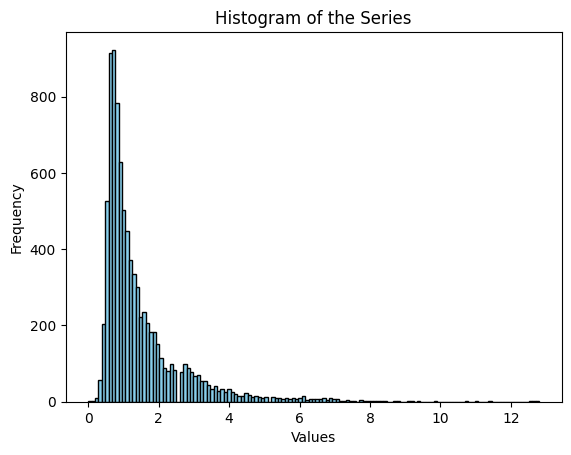

In [ ]:
import matplotlib.pyplot as plt

plt.hist(
    df_icu_target["valuenum"],
    bins="auto",
    color="skyblue",
    edgecolor="black",
)
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram of the Series")
plt.show()

#### mark with is_akd

[x] Drop all non CREATININE

[ ] akd_condition
1. value >= CREATININE_MAX
1. max_mesure / min_mesure >= CREATININE_FRAC
1. 2 consecutive mesure .diff() > CREATININE_DELTA

In [ ]:
CREATININE_FRAC = 1.5
CREATININE_DELTA = 0.3
CREATININE_MAX = 15/133.12 * 10  ## convert 15mg/mmol to mg/dl 

# mark by max value 
df_icu_target.loc[:, "is_akd"] = df_icu_target["valuenum"] >= CREATININE_MAX

# mark by delta and max:min 
df_icu_group = df_icu_target.groupby("stay_id")
for group_name, group_data in df_icu_group :
    # mark consecutive delta 
    # make sure sorted 
    group_data = group_data.sort_values(by="charttime")
    group_data["is_akd"] = group_data["is_akd"] | (abs(group_data['valuenum'].diff()) > CREATININE_DELTA)
 
    # mark by max/min 
    maxIdx = group_data["valuenum"].idxmax()
    minIdx = group_data["valuenum"].idxmin()
    
    if ((group_data["valuenum"][minIdx] == 0) or (group_data["valuenum"][maxIdx] / group_data["valuenum"][minIdx] > CREATININE_FRAC)) :
        laterIdx = maxIdx if maxIdx > minIdx else minIdx  # type: ignore
        group_data.loc[laterIdx, "is_akd"] = True
        pass
    pass


df_icu_target.to_csv(TEMP_PATH / "icu_target.csv");


/tmp/ipykernel_1894355/1369531332.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_icu_target.loc[:, "is_akd"] = df_icu_target["value"] >= CREATININE_MAX


In [ ]:
print("Total patients: " + str(len(df_icu_target["hadm_id"].unique())))
print("Total admission: " + str(len(df_icu_target["stay_id"].unique())))
print("Total mesurements: " + str(len(df_icu_target)))
print("Total mesurements are akd-positive: " + str(df_icu_target["is_akd"].sum()))

Total patients: 1205
Total admission: 1205
Total mesurements: 8866
Total mesurements are akd-positive: 3870


There are more akd-positive mesurements than admissions so each may contains serveral times when patients got akd, then cured, then happend again.

#### find other important mesurement 

In [ ]:
# TODO: find real mesurements 
ckd_related_mesures = ["dsds"]

#### Split so that each rows contains a time series of mesures 